<a href="https://colab.research.google.com/github/arkache/Lab-2/blob/main/Lab_2_Analisis_de_sent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install googletrans==3.1.0a0
!pip install spacy networkx matplotlib
!python -m spacy download es_core_news_sm
# Instalar las bibliotecas necesarias
!pip install transformers torch scikit-learn wordcloud matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 392.0 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [21]:
import pandas as pd
from textblob import TextBlob
import nltk
from googletrans import Translator



In [22]:
def translateComment(strComment:str):
    translator = Translator()

    strEngComment = translator.translate(strComment, src="es", dest="en")
    return strEngComment.text

def getPolarity(strComment:str):
    strComment = translateComment(strComment)

    analysis = TextBlob(strComment)
    return analysis.sentiment.polarity


In [15]:

# Cargamos el dataset
df = pd.read_csv('/content/Copia de Comentarios.csv')
df['polaridad'] = df['Comentario'].apply(getPolarity)

df.to_csv('resultados.csv', index=False)



In [16]:
# En una celda separada
df = pd.read_csv('/content/resultados.csv')
display(df)

,Comentario,polaridad
0,La comida fue excelente y el servicio fue exce...,0.555556
1,El ambiente era agradable y la comida estaba d...,0.261458
2,"La comida estaba bien, pero el servicio fue le...",0.200000
3,"No me gustó la comida, estaba fría y el sabor ...",-0.475000
4,El peor restaurante en el que he estado. No lo...,-1.000000
...,...,...
66,Siempre disfruto venir aquí. La comida es deli...,0.629167
67,"Buen lugar para cenar, aunque el servicio pued...",0.070833
68,"La comida está bien, pero el ambiente no es mu...",0.208974
69,No me gustó la comida y el servicio fue muy de...,-0.520000


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import files
import io

In [39]:

# Cargar el tokenizador y el modelo BERT para español
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Por favor, sube tu archivo CSV.


Saving Copia de Comentarios.csv to Copia de Comentarios (4).csv
Columnas en el DataFrame:
Index(['Comentario'], dtype='object')
Introduce el nombre de la columna que contiene los comentarios: Comentario


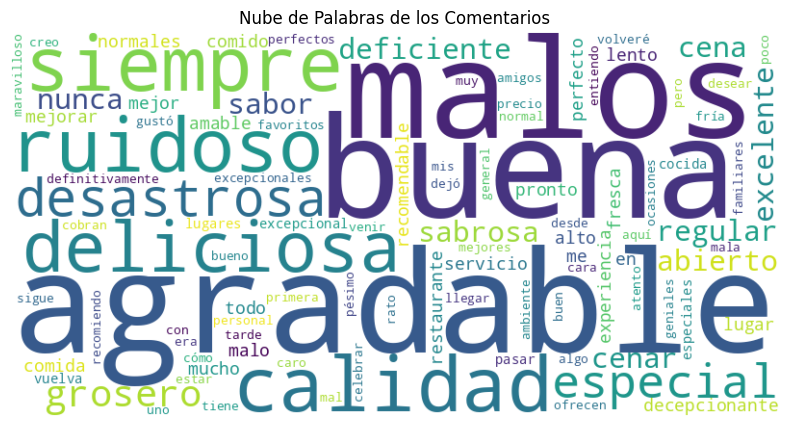

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Palabras clave más relevantes:
agradable: 0.4034
buena: 0.4030
malos: 0.3874
siempre: 0.3783
calidad: 0.3783
ruidoso: 0.3692
deliciosa: 0.3675
desastrosa: 0.3648
especial: 0.3636
grosero: 0.3594
regular: 0.3582
nunca: 0.3542
cena: 0.3520
sabrosa: 0.3520
excelente: 0.3516
sabor: 0.3494
deficiente: 0.3454
abierto: 0.3441
cenar: 0.3429
decepcionante: 0.3413


<Figure size 640x480 with 0 Axes>

In [41]:

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

def extract_keywords(text, top_n=10):
    embedding = get_bert_embeddings(text)
    vectorizer = CountVectorizer().fit([text])
    words = vectorizer.get_feature_names_out()
    word_embeddings = [get_bert_embeddings(word) for word in words]
    similarities = [torch.cosine_similarity(torch.tensor(embedding), torch.tensor(we), dim=0).item() for we in word_embeddings]
    word_sim_tuples = sorted(zip(words, similarities), key=lambda x: x[1], reverse=True)
    return dict(word_sim_tuples[:top_n])

# Cargar el dataset
print("Por favor, sube tu archivo CSV.")
uploaded = files.upload()

# Obtener el nombre del archivo subido
file_name = list(uploaded.keys())[0]

# Cargar el DataFrame
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Verificar las columnas del DataFrame
print("Columnas en el DataFrame:")
print(df.columns)

# Solicitar al usuario el nombre de la columna de comentarios
column_name = input("Introduce el nombre de la columna que contiene los comentarios: ")

# Combinar todos los comentarios en un solo texto
all_text = " ".join(df[column_name].astype(str))

# Extraer palabras clave
keywords = extract_keywords(all_text, top_n=100)

# Crear y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keywords)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de los Comentarios')
plt.show()

# Guardar la imagen
plt.savefig('wordcloud.png')
files.download('wordcloud.png')

# Imprimir las palabras clave más relevantes
print("\nPalabras clave más relevantes:")
for word, relevance in sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word}: {relevance:.4f}")

Explicación de los resultados:
El valor que ves junto a cada palabra (por ejemplo, 0.4034 para "agradable") representa la relevancia o similitud de esa palabra con respecto al contenido general de todos los comentarios. Este valor se calcula utilizando la similitud del coseno entre el embedding de la palabra y el embedding promedio de todos los comentarios. Un valor más alto indica que la palabra es más representativa o relevante en el contexto de tus comentarios.
Ahora, vamos a realizar un análisis adicional utilizando el mismo modelo BERT. Este nuevo código se centrará en:

Clasificación de sentimientos
Agrupación (clustering) de comentarios similares
Extracción de temas principales

Aquí tienes el código adicional:
Análisis Avanzado de Comentarios con BERTClick to open code
Este código realiza los siguientes análisis:

Clasificación de sentimientos: Utiliza un modelo BERT multilingüe para clasificar cada comentario en una escala de 1 a 5 estrellas.
Agrupación de comentarios: Utiliza K-means para agrupar los comentarios en 5 clusters basados en sus embeddings de BERT.
Extracción de temas principales: Usa PCA para reducir la dimensionalidad de los embeddings y visualizar los clusters.
Análisis de resultados: Muestra la distribución de sentimientos y las palabras más comunes en cada cluster.

Para usar este código:

Asegúrate de que el archivo 'Copia de Comentarios.csv' esté en el mismo directorio que este script.
Ejecuta el código en una nueva celda de Colab.
Revisa los resultados impresos y los archivos generados.

Interpretación de los resultados:

La distribución de sentimientos te dará una idea general de cómo se sienten los clientes.
Los clusters te ayudarán a identificar grupos de comentarios similares, lo que podría revelar temas o patrones comunes.
Las palabras más comunes en cada cluster te darán una idea de los temas principales de cada grupo.
La visualización de clusters te permitirá ver cómo se agrupan los comentarios en el espacio bidimensional.

Este análisis te proporcionará una visión más profunda de tus datos, permitiéndote identificar patrones, temas recurrentes y la distribución general del sentimiento en los comentarios.
¿Hay algún aspecto específico de este análisis que te gustaría explorar más a fondo o alguna pregunta sobre cómo interpretar los resultados?

In [43]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel, pipeline
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter

# Cargar el modelo y el tokenizador
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Cargar el clasificador de sentimientos
sentiment_classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Cargar los datos
df = pd.read_csv('Copia de Comentarios.csv')

# 1. Clasificación de sentimientos
df['sentiment'] = df['Comentario'].apply(lambda x: sentiment_classifier(x[:512])[0]['label'])

# 2. Agrupación de comentarios
embeddings = np.array(df['Comentario'].apply(get_bert_embedding).tolist())
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

# 3. Extracción de temas principales
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualización
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Agrupación de Comentarios')
plt.colorbar(scatter)
plt.savefig('comment_clusters.png')
plt.close()

# Análisis de resultados
print("Distribución de Sentimientos:")
print(df['sentiment'].value_counts(normalize=True))

print("\nPalabras más comunes por cluster:")
for cluster in range(5):
    cluster_comments = ' '.join(df[df['cluster'] == cluster]['Comentario'])
    words = cluster_comments.split()
    print(f"\nCluster {cluster}:")
    print(Counter(words).most_common(10))

# Guardar resultados
df.to_csv('comentarios_analizados.csv', index=False)
print("\nResultados guardados en 'comentarios_analizados.csv'")
print("Visualización de clusters guardada en 'comment_clusters.png'")

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Distribución de Sentimientos:
sentiment
1 star     0.253521
5 stars    0.225352
3 stars    0.197183
2 stars    0.183099
4 stars    0.140845
Name: proportion, dtype: float64

Palabras más comunes por cluster:

Cluster 0:
[('comida', 5), ('el', 5), ('La', 4), ('y', 4), ('servicio', 3), ('lugar.', 2), ('fueron', 2), ('de', 2), ('primera.', 2), ('son', 2)]

Cluster 1:
[('comida', 8), ('lugar', 8), ('y', 7), ('La', 5), ('el', 5), ('para', 4), ('Un', 4), ('No', 4), ('recomendaría', 4), ('este', 4)]

Cluster 2:
[('en', 5), ('he', 5), ('que', 4), ('El', 3), ('peor', 3), ('restaurante', 3), ('el', 3), ('estado.', 3), ('No', 2), ('Muy', 2)]

Cluster 3:
[('y', 23), ('comida', 21), ('el', 18), ('La', 15), ('servicio', 14), ('fue', 14), ('estaba', 10), ('la', 10), ('muy', 8), ('no', 7)]

Cluster 4:
[('el', 14), ('comida', 12), ('aunque', 8), ('La', 8), ('pero', 8), ('un', 7), ('es', 7), ('ambiente', 6), ('y', 6), ('poco', 6)]

Resultados guardados en 'comentarios_analizados.csv'
Visualización de cl